In [1]:
#Librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np     

# MMM Tráfico

Vamos a comenzar construyendo un modelo de regresión para estimar el tráfico físico en tienda:

$$
\text{Tráfico\_físico}_t = \beta_0 + \beta_1 \cdot \text{Tráfico\_físico}_{t-1} + \beta_2 \cdot \text{INV\_online}_t + \beta_3 \cdot \text{INV\_offline}_t + \sum_{i=4}^{n} \beta_i \cdot X_{i,t} + \varepsilon_t
$$

**Donde:**
- **$\beta_0$**: Es el intercepto del modelo (nivel base de tráfico sin inversión ni efecto del pasado).
- **$\text{Tráfico\_físico}_{t-1}$**: Valor del tráfico físico en tienda del mes anterior (*delay*).
- **$\text{INV\_online}_t$**: Inversión publicitaria en medios digitales en el mes actual.
- **$\text{INV\_offline}_t$**: Inversión publicitaria en medios tradicionales en el mes actual.
- **$\sum_{i=4}^{n} \beta_i \cdot X_{i,t}$**: Variables exógenas que pueden influir en el tráfico, como:
  - Tráfico web total
  - Días festivos o fines de semana
  - Eventos comerciales (Black Friday, rebajas, etc.)
- **$\varepsilon_t$**: Término de error del modelo, que recoge la variabilidad no explicada por las variables anteriores.

## Tabla Final

A continuación cargamos todas las tablas que vamos a emplear para el modelo de atribución:

In [2]:
df_web = pd.read_csv("../data/raw/web.csv", sep=",")
df_offline = pd.read_csv("../data/raw/offline.csv", sep=",")
df_time = pd.read_csv("../data/raw/time.csv", sep=",")
df_visit = pd.read_csv("../data/raw/visit.csv", sep=",")
df_inv = pd.read_csv("../data/raw/inv.csv", sep=",")

Tenemos que añadir los sufijos web y offline a las columans de estas tablas ya que sus nombre coinciden y posteriormente al hacer el merge necesitamos distinguirlas.

In [3]:
df_offline = df_offline.rename(columns={
    col: f"{col}_off" for col in df_offline.columns if col != "ID_Date"})


df_visit = df_visit.rename(columns={
    col: f"{col}_visit" for col in df_visit.columns if col != "ID_Date"})


**Tabla Inversión**

Se han generado las siguientes métricas a partir de la tabla de inversión mensual(de cara a facilitar la evaluación del budget):

- `Pct_Online`: porcentaje de la inversión total del mes destinada a medios online.
- `Pct_Offline`: porcentaje de la inversión total del mes destinada a medios offline.


In [4]:
inversion_online = df_inv['INTERNET'] + df_inv['PlataformasVideo']


inversion_offline = (
    df_inv['CINE'] + df_inv['EXTERIOR'] + df_inv['PRENSA'] +
    df_inv['RADIO'] + df_inv['REVISTAS']+df_inv['PRODUCCION'] + df_inv['VARIOS']
)


df_inv['Inversion_Online'] = inversion_online
df_inv['Inversion_Offline'] = inversion_offline



In [5]:
df_inv.head()

,ID_Date,CINE,EXTERIOR,INTERNET,PRENSA,PRODUCCION,RADIO,REVISTAS,PlataformasVideo,VARIOS,INV_Total,Inversion_Online,Inversion_Offline
0,202201,59887.84,8200.00,133666.43,0.0,6050.0,2426.40,18013.50,338824.94,7531.03,574600.14,472491.37,102108.77
1,202202,72291.56,94627.51,189275.94,10000.0,6700.0,0.00,49110.91,487537.14,6972.02,916515.08,676813.08,239702.00
2,202203,55000.00,0.00,214037.62,4500.0,3700.0,0.00,0.00,75000.00,15284.85,367522.47,289037.62,78484.85
3,202204,10883.30,0.00,194816.97,48800.0,21550.0,1140.00,40876.00,610865.89,12255.75,941187.91,805682.86,135505.05
4,202205,74333.20,0.00,130795.16,11000.0,4900.0,102851.86,20775.75,393807.74,7926.46,746390.17,524602.90,221787.27


**Merge para Tabla Final**

In [9]:
# Union todas las tablas por PK=ID_date
df_merge = df_inv.merge(df_web, on='ID_Date')
df_merge = df_merge.merge(df_offline, on='ID_Date')
df_merge = df_merge.merge(df_time, on='ID_Date')
df_merge = df_merge.merge(df_visit, on='ID_Date')
df_merge = df_merge.sort_values('ID_Date')

# Calculamos el delay de compras
df_merge['Sales_1_ago'] = df_merge['Sales_off'].shift(1) # 1 mes atras
df_merge['Sales_2_ago'] = df_merge['Sales_off'].shift(2) # 2 meses atras
df_merge['Web_Visitors_1_ago']=df_merge['Unique_visitors'].shift(1)

*Nota*:Para los primeros dos meses deconcoemos los visitantes previos pero los dejamos como NaN para que lo gestione el modelo.

In [10]:
df_merge.head()

,ID_Date,CINE,EXTERIOR,INTERNET,PRENSA,PRODUCCION,RADIO,REVISTAS,PlataformasVideo,VARIOS,...,RopaMujer_visit,Complementos_visit,Zapatos_visit,Home_visit,Interior_visit,Otros_visit,SR_Total_visit,Sales_1_ago,Sales_2_ago,Web_Visitors_1_ago
0,202201,59887.84,8200.00,133666.43,0.0,6050.0,2426.40,18013.50,338824.94,7531.03,...,81289,16190,36790,18848,9906,183,213346,NaN,NaN,NaN
1,202202,72291.56,94627.51,189275.94,10000.0,6700.0,0.00,49110.91,487537.14,6972.02,...,152805,26083,37960,20047,11057,461,299630,1299.0,NaN,272382.0
2,202203,55000.00,0.00,214037.62,4500.0,3700.0,0.00,0.00,75000.00,15284.85,...,68383,18109,37765,20105,66200,198,259923,1752.0,1299.0,352581.0
3,202204,10883.30,0.00,194816.97,48800.0,21550.0,1140.00,40876.00,610865.89,12255.75,...,65126,16985,76244,17629,17827,176,242206,1897.0,1752.0,332955.0
4,202205,74333.20,0.00,130795.16,11000.0,4900.0,102851.86,20775.75,393807.74,7926.46,...,44577,16498,79434,18526,10738,186,212188,1546.0,1897.0,282169.0


## Correlaciones Tráfico físico

A continuación ,antes de ajustar la regresión vamos a estudiar qué variables exógenas podíamos incluir por tabla:
- `Inv`    (no la tenemos en cuenta porque ya lo estamos metiendo con el presupuesto)
- `Offline` (cómo afectan variables como ticket medio/mercado a las ventas)
- `Time `   (cómo afectan distintos periodos de tiempo a las compras)
- `Visit` (dentro de la web cómo afectan las visitas a la disitntas páginas sobre las compras)
- `Web `   (cómo afectan las visitas a la web sobre las compras en tienda)

### Tabla Time

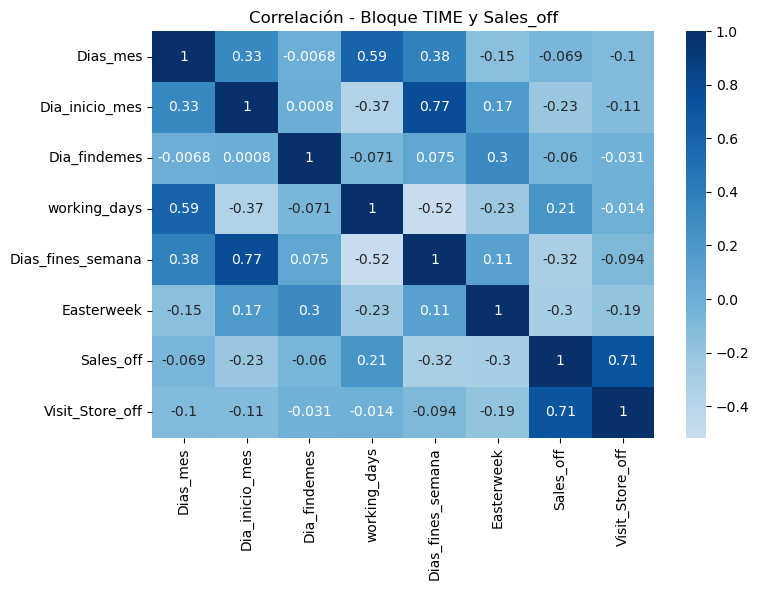

In [13]:
cols_time = ['Dias_mes', 'Dia_inicio_mes', 'Dia_findemes', 'working_days', 'Dias_fines_semana', 'Easterweek' ,'Sales_off','Visit_Store_off']

df_time_corr = df_merge[cols_time]
corr_time = df_time_corr.corr(numeric_only=True)


plt.figure(figsize=(8, 6))
sns.heatmap(corr_time, annot=True, cmap='Blues', center=0)
plt.title("Correlación - Bloque TIME y Sales_off")
plt.tight_layout()
plt.show()


**Variables Más Correlacionadas en Time con Sales**

In [46]:
df_merge.groupby('Easterweek')['Sales_off'].mean()


Easterweek
0    1762.272727
1    1451.333333
Name: Sales_off, dtype: float64

In [47]:
df_merge.groupby('Dias_fines_semana')['Sales_off'].mean()

Dias_fines_semana
8     1812.526316
9     1715.666667
10    1578.750000
Name: Sales_off, dtype: float64

Finalmente las varibales que más influyen sobre las ventas son:

| Variable            |  Sales_off | Sentido de la relación                            |
|---------------------|------------------------------|----------------------------------------------------|
| Dias_fines_semana | **–0.32**                   | A más fines de semana, menos ventas                |
| Easterweek        | **–0.30**                   | Semana Santa reduce ventas                         |
| working_days      | **+0.21**                   | A más días laborables, más ventas                  |



### Tabla Inv

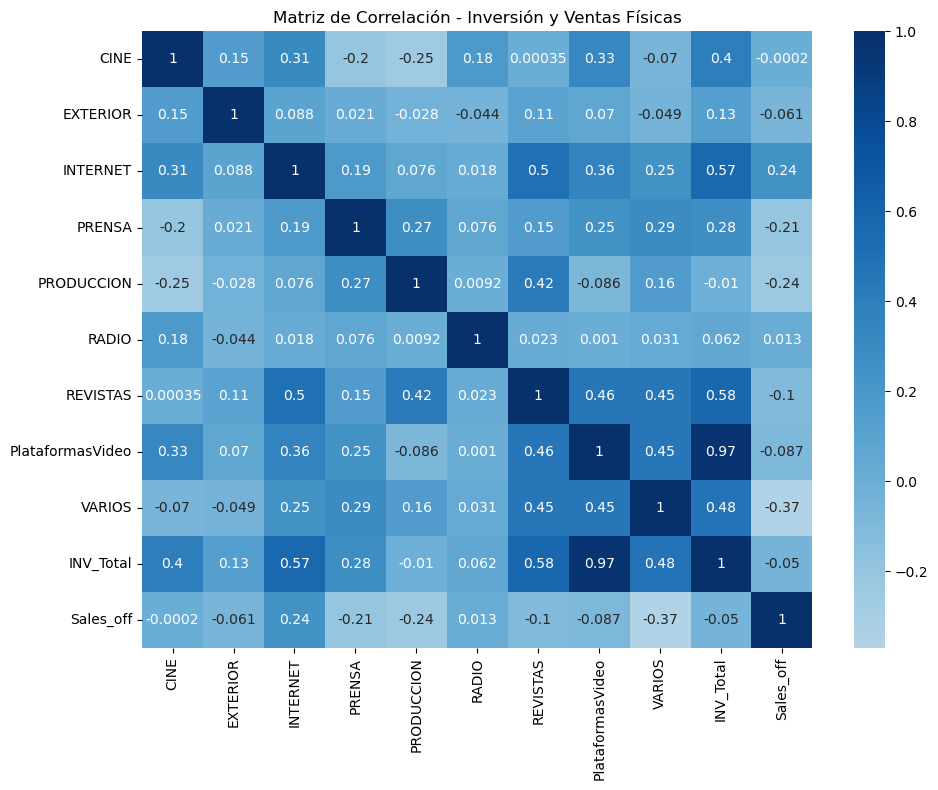

In [48]:
cols_inv = [
    'CINE', 'EXTERIOR', 'INTERNET', 'PRENSA', 'PRODUCCION',
    'RADIO', 'REVISTAS', 'PlataformasVideo', 'VARIOS',
    'INV_Total', 'Sales_off'
]


df_inv_corr = df_merge[cols_inv]
corr_inv = df_inv_corr.corr(numeric_only=True)


plt.figure(figsize=(10, 8))
sns.heatmap(corr_inv, annot=True, cmap='Blues', center=0)
plt.title("Matriz de Correlación - Inversión y Ventas Físicas")
plt.tight_layout()
plt.show()

**Variables de INV más correlacionadas con Sales**

Aunque incialmente agrupamos la inversión en medios offline y online, hemos decicido analizar más fondo la relación de la publidad en cada medio con las ventas


 Variables con correlación **positiva** 

| Variable   | Correlación | Interpretación breve                            |
|------------|-------------|--------------------------------------------------|
| INTERNET | +0.24 | Invertir en internet se asocia a más ventas                  |

 Variables con correlación **negativa**

| Variable     | Correlación | Interpretación breve                               |
|--------------|-------------|-----------------------------------------------------|
| VARIOS     | –0.37  | Inversión en canales diversos resta a las ventas   |
| PRODUCCION | –0.24  | Posible coste sin retorno inmediato                |
|PRENSA     |–0.21   | Canales tradicionales podrían tener menor impacto  |



### Tabla Web

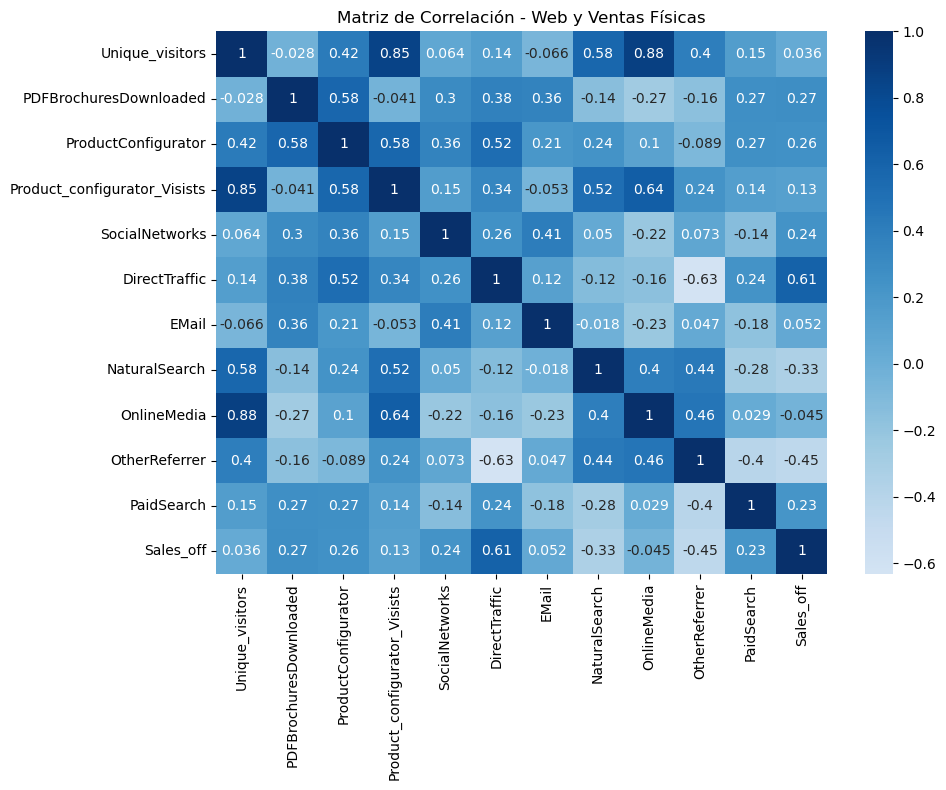

In [49]:

# Columnas del bloque WEB y ventas físicas
cols_web = [
    'Unique_visitors', 'PDFBrochuresDownloaded', 'ProductConfigurator',
    'Product_configurator_Visists', 'SocialNetworks', 'DirectTraffic',
    'EMail', 'NaturalSearch', 'OnlineMedia', 'OtherReferrer', 'PaidSearch',
    'Sales_off'
]


df_web_corr = df_merge[cols_web]
corr_web = df_web_corr.corr(numeric_only=True)


plt.figure(figsize=(10, 8))
sns.heatmap(corr_web, annot=True, cmap='Blues', center=0)
plt.title("Matriz de Correlación - Web y Ventas Físicas")
plt.tight_layout()
plt.show()



**Variables más correlacionados con Sales**

Variables con correlación **positiva**

| Variable                  | Correlación | Significado                                                         |
|---------------------------|-------------|---------------------------------------------------------------------|
| DirectTraffic            | +0.61       | Usuarios que acceden directamente al sitio web. Alta intención de compra y conversión. |
| PDFBrochuresDownloaded   | +0.27       | Descarga de catálogos = mayor interés en los productos.            |
| ProductConfigurator     | +0.26       | Uso del configurador de productos = intención clara de compra.     |
| SocialNetwork         | +0.24       | Tráfico proveniente de redes sociales, aumenat ventas. |

Variables con correlación **negativa**

| Variable                  | Correlación | Significado                                                         |
|---------------------------|-------------|---------------------------------------------------------------------|
| OtherReferrer            | –0.45       | Tráfico proveniente de webs externas, sin intención clara de compra.|
| NaturalSearch          | –0.33       | Resutados que que sugiere directamente el navegador|



### Tabla Visit

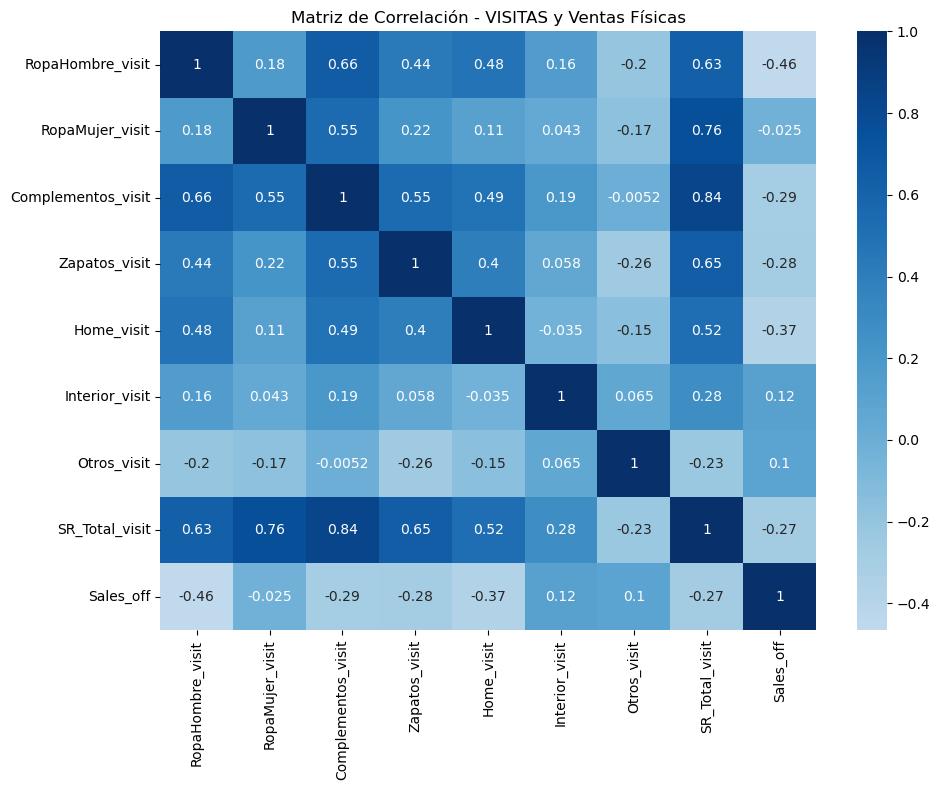

In [50]:
cols_visit = [
    'RopaHombre_visit', 'RopaMujer_visit', 'Complementos_visit', 
    'Zapatos_visit', 'Home_visit', 'Interior_visit', 'Otros_visit', 
    'SR_Total_visit', 'Sales_off'
]


df_visit_corr = df_merge[cols_visit]


corr_visit = df_visit_corr.corr(numeric_only=True)


plt.figure(figsize=(10, 8))
sns.heatmap(corr_visit, annot=True, cmap='Blues', center=0)
plt.title("Matriz de Correlación - VISITAS y Ventas Físicas")
plt.tight_layout()
plt.show()


### Tabla Offline

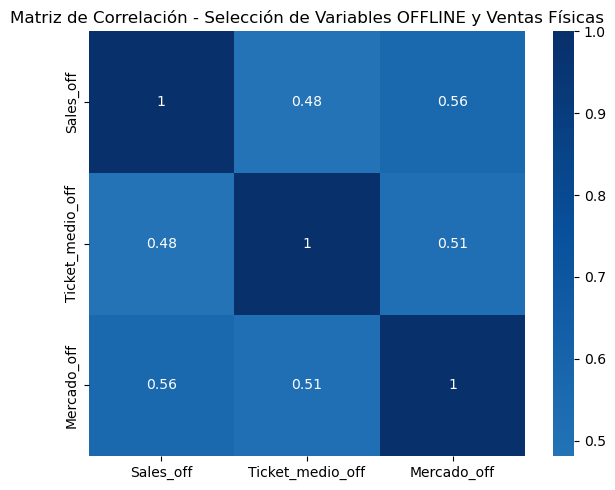

In [51]:

cols_selected = ['Sales_off', 'Ticket_medio_off', 'Mercado_off']

df_selected_corr = df_merge[cols_selected]
corr_selected = df_selected_corr.corr(numeric_only=True)

# Generar el heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_selected, annot=True, cmap='Blues', center=0)
plt.title("Matriz de Correlación - Selección de Variables OFFLINE y Ventas Físicas")
plt.tight_layout()
plt.show()
